<a href="https://colab.research.google.com/github/Ahbar1999/mtp-pimsimulator/blob/main/pimsimulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Code Summary**


*   In the (wear count and address translation) arrays and indices of the arrays are logical array ids   
*   For intra crossbar wear levelling, row swapping is being implemented as given in the TIME paper, DRCTL implements intra crossbar wear levelling by doing continuous shifting of row, columns which does not take into account the dynamic ageing
*   For inter crossbar wear levelling, TIWL's approach is being implemented
*   Currently the writes are being accumulated per xbar, we need to accumulate writes per cell

Implmentation References:
*   ODLPIM: https://past.date-conference.com/proceedings-archive/2023/DATA/357.pdf
*   DRCTL:  https://ieeexplore.ieee.org/document/10764631
*   TIME:   https://dl.acm.org/doi/10.1145/3195970.3196071

**TO-DO**



*   Find the statistic used in the paper for determining performance of intra crossbar wear levelling, use it find results
*   Find out why the max write of in rows is increasing after row swapping
*   There is no mechanism to simulate Data swapping, we are just changing teh address mappings but the data at those addressed needs to be swapped too, maybe add overhead for writes or something to simulate that
*   Currently only the gradient weights i.e. memory thats being written to, is monitored, we dont know how the other memory access i.e reads are taking place, also when you change address mappings, how are the memory accesses dependent on changed mappings get affected ?



**Learnings/Experiments**

*   Row swapping intervals/ min-max ratio thresholds to swap:
      Using smaller min-max ratio and smaller swapping intervals did not result in smaller max-count for rows because of ???
*        



In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
class PIMSimulator:
    def __init__(self, num_crossbars=1024, crossbar_size=(128, 128), bits_per_cell=1, weight_bits=8, wear_levelling_enabled=True, intra_xbar_wear_levelling_enabled=True):
        """Config params"""
        self.num_crossbars = num_crossbars
        self.crossbar_rows, self.crossbar_cols = crossbar_size
        self.bits_per_cell = bits_per_cell  # bit resolution of each reram cell
        # (quantization)bits per weight
        self.weight_bits = weight_bits
        self.wear_levelling_enabled = wear_levelling_enabled
        self.intra_xbar_wear_levelling_enabled = intra_xbar_wear_levelling_enabled

        # Calculate how many weights fit in one crossbar
        self.cells_per_crossbar = self.crossbar_rows * self.crossbar_cols
        self.weights_per_crossbar = self.cells_per_crossbar // self.weight_bits

        # interval write counters for each crossbar
        self.iwc_counters = np.zeros(num_crossbars, dtype=np.uint32)
        # total write counters for each crossbar
        self.twc_counters = np.zeros(num_crossbars, dtype=np.uint64)

        # addressing granularity is a crossbar
        # LAID -> PAID: initial mapping is i -> i
        self.access_count = 0                   # xbar memory accesses
        self.access_count_for_rows = 0
        self.remapping_interval = 1000

        self.tensor_registry = {}           # tensor_name -> segment_list
        # the following map should be changed to xbar_base_addr -> xbar_object
        # the crossbar object will have an address field
        self.laid_to_paid_map = {}          # logical to physical xbar ids
        self.next_laid = 0                  # next free LAID(that maps to physical id)
        self.next_physical_crossbar = 0     # next free PAID(of the actual crossbar)

        # row mapping code
        # write count 2D array for xbar * rows_per_xbar
        # [physical xbar id][physical row id]
        self.row_write_counts = np.zeros((num_crossbars, self.crossbar_rows), dtype=np.int64)
        self.row_mappings = [list(range(self.crossbar_rows)) for _ in range(num_crossbars)]

        # row max / min
        self.row_swap_threshold = 2.0
        # swap rows every row_swap_interval writes
        self.row_swap_interval = 10000
        self.total_row_swaps =0

        print(f"Crossbar config: {crossbar_size}, {self.weights_per_crossbar} weights per crossbar")
        if not self.wear_levelling_enabled:
          print("Wear levelling disabled")

    def register_model(self, model):
        """Build collision-free mapping for all tensors once before running the model"""
        for name, param in model.named_parameters():
            # generate mapping for trainable parameters
            if param.requires_grad:
                # segment are basically individual xbar mappings for the whole tensor
                segments = self._partition_tensor(name, param)
                self.tensor_registry[name] = segments

    def _partition_tensor(self, tensor_name, tensor):
        """Distribute tensor weights to xbars"""
        tensor_size = tensor.numel()
        crossbars_needed = math.ceil(tensor_size / self.weights_per_crossbar)

        segments = []
        remaining_elements = tensor_size

        for i in range(crossbars_needed):
            laid = self.next_laid
            if self.next_physical_crossbar >= self.num_crossbars:
                raise ValueError(f"Not enough crossbars for tensor {tensor_name}, exiting program.")

            paid = self.next_physical_crossbar
            elements = min(remaining_elements, self.weights_per_crossbar)

            segments.append({
                'laid': laid,
                'paid': paid,
                'elements': elements,
                'logical_offset': tensor_size - remaining_elements
            })

            # Initial i -> i mapping
            self.laid_to_paid_map[laid] = paid

            self.next_laid += 1
            self.next_physical_crossbar += 1
            remaining_elements -= elements

        return segments

    def log_memory_access(self, tensor_name, is_write=True):
        """Accurate logging considering tensor size and crossbar capacity"""
        if not is_write or tensor_name not in self.tensor_registry:
            return

        xbars = self.tensor_registry[tensor_name]

        for xbar in xbars:
            laid = xbar['laid']
            current_paid = self.laid_to_paid_map[laid]  # address translation
            elements = xbar['elements']

            writes_per_element = self.weight_bits // self.bits_per_cell
            total_writes = elements * writes_per_element

            # record interval write count for current xbar
            self.iwc_counters[current_paid] += total_writes

            self._log_row_level_writes(laid, elements, total_writes)

        self.access_count += 1
        self.access_count_for_rows += 1

        if self.access_count % self.remapping_interval == 0:
            self.perform_remapping()

        if self.access_count_for_rows % self.remapping_interval == 0:
            self.perform_row_remapping()

    def _log_row_level_writes(self, crossbar_laid, elements, total_writes):
        weights_per_row = self.crossbar_cols * (self.bits_per_cell // self.weight_bits)
        if weights_per_row <= 0:
            weights_per_row = self.crossbar_cols // 8  # Fallback: assume 8-bit weights

        rows_affected = math.ceil(elements / weights_per_row)
        writes_per_row = total_writes // rows_affected if rows_affected > 0 else total_writes

        # assert(rows_affected <= 128)

        for logical_row in range(min(rows_affected, self.crossbar_rows)):
            physical_xbar = self.laid_to_paid_map[crossbar_laid]
            # physical_row = self.row_mappings[crossbar_laid][logical_row]
            physical_row = self.row_mappings[crossbar_laid][logical_row]
            # assert(physical_xbar < 128 and physical_row < 128)
            self.row_write_counts[physical_xbar][physical_row] += writes_per_row

    # this has to be performed within each xbar
    def perform_row_remapping(self):
        if not self.wear_levelling_enabled or not self.intra_xbar_wear_levelling_enabled:
          return

        """Perform new swapping within crossbars to balance row-level wear"""
        """Swaps 2 highest and lowest utilized rows in xbars"""
        # print("Performing Row Remapping...")

        # crossbar_id <-> laid
        for crossbar_id in range(self.num_crossbars):
          row_counts = self.row_write_counts[crossbar_id]

          if np.sum(row_counts) == 0:
            continue

          max_wear_physical = np.max(row_counts)  # maximum write count
          min_wear_physical = np.min(row_counts)  # minimum write count

          if min_wear_physical == 0 or (max_wear_physical / min_wear_physical) < self.row_swap_threshold:
            continue

          # get logical id of the rows with min, max write counts
          max_logical = np.argmax(row_counts)
          min_logical = np.argmin(row_counts)

          # swap physical ids of the min/max rows
          self.row_mappings[crossbar_id][max_logical] = self.row_mappings[crossbar_id][min_logical]
          self.row_mappings[crossbar_id][min_logical] = self.row_mappings[crossbar_id][max_logical]

          self.total_row_swaps += 1
          # print("row swapped")
          # # exit(0)

          # Optional: Log the swap
          if self.access_count % (self.row_swap_interval * 10) == 0:  # Log occasionally
            print(f"Row swap in crossbar {crossbar_id}: "
                  f"logical {max_logical}→physical {min_wear_physical}, "
                  f"logical {min_logical}→physical {max_wear_physical} "
                  f"(wear ratio: {max_wear_physical/min_wear_physical:.2f})")

    """
      TODO:
        add a parameter 'k' to the following function which allows you to choose top K% xbars to swap
        default case should be remapping all xbars
    """
    def perform_remapping(self):
        # print("Updating write counters")
        # Update Total Wear Count (TWC)
        for laid, iwc in enumerate(self.iwc_counters):
            paid = self.laid_to_paid_map.get(laid, laid)
            self.twc_counters[paid] += iwc
            self.iwc_counters[laid] = 0  # Reset interval counter

        if not self.wear_levelling_enabled:
            # print("wear levelling has been disabled!")
            return

        # print("Performing Remapping...")
        # Sort crossbars by wear level (TWC)
        wear_sorted_crossbars = sorted(enumerate(self.twc_counters), key=lambda x: x[1])

        # Sort logical crossbars by hotness (recent writes)
        hotness_sorted = sorted(enumerate(self.iwc_counters), key=lambda x: x[1], reverse=True)

        # Rebuild mapping: hottest logical → coolest physical
        new_mapping = {}
        # (hot laid, hotness value)
        for i, (hot_laid, _) in enumerate(hotness_sorted):
            cool_paid, _ = wear_sorted_crossbars[i]  # Least worn physical crossbar
            new_mapping[hot_laid] = cool_paid

        # print("change in mappings: ")
        # for laid in new_mapping:
        #   if self.laid_to_paid_map[laid] != new_mapping[laid]:
        #     print(f"{laid}: {self.laid_to_paid_map[laid]} -> {new_mapping[laid]}")

        self.laid_to_paid_map = new_mapping
        # print(f"New mapping: {self.laid_to_paid_map}")

    def get_crossbar_utilization_stats(self):
        """Analyze crossbar utilization patterns"""
        stats = {
            'total_crossbars': self.num_crossbars,
            'weights_per_crossbar': self.weights_per_crossbar,
            'active_crossbars': np.count_nonzero(self.iwc_counters),
            'avg_wear': np.mean(self.twc_counters),
            'max_wear': np.max(self.twc_counters),
            'wear_imbalance': np.max(self.twc_counters) / (np.min(self.twc_counters) + 1)
        }
        return stats

    def get_row_wear_statistics(self):
      """
      Row-level wear statistics after considering intra-crossbar row swapping.
      Also returns crossbar-level stats derived from row data and reduction metrics.
      Relies on:
        - self.row_write_counts: shape (num_crossbars, crossbar_rows), physical rows
        - self.row_mappings: logical->physical mapping (not needed to read counts since counts are stored on physical rows)
        - self._total_row_swaps: optional counter (defaults to 0 if absent)
      """
      wear_rows = self.row_write_counts  # shape (C, R), physical rows
      row_sums_per_xbar = wear_rows.sum(axis=1)
      active_xbar_mask = row_sums_per_xbar > 0
      active_rows = wear_rows[active_xbar_mask]

      if active_rows.size == 0:
          return {
              'max_row_wear': 0,
              'min_row_wear': 0,
              'avg_row_wear': 0.0,
              'row_wear_imbalance': 1.0,
              'active_crossbars': 0,
              'total_row_swaps': int(getattr(self, 'total_row_swaps', 0)),
              # Aggregates per crossbar from row totals
              'max_xbar_wear_from_rows': 0,
              'min_xbar_wear_from_rows': 0,
              'avg_xbar_wear_from_rows': 0.0,
              'xbar_wear_imbalance_from_rows': 1.0
          }

      flat = active_rows.flatten()
      nonzero = flat[flat > 0]
      max_row = int(flat.max())
      min_row_active = int(nonzero.min()) if nonzero.size > 0 else 0
      avg_row = float(nonzero.mean()) if nonzero.size > 0 else 0.0
      row_imbalance = (max_row / min_row_active) if min_row_active > 0 else 1.0

      xbar_totals = active_rows.sum(axis=1)
      max_xbar = int(xbar_totals.max())
      min_xbar_active = int(xbar_totals[xbar_totals > 0].min()) if np.any(xbar_totals > 0) else 0
      avg_xbar = float(xbar_totals.mean()) if xbar_totals.size > 0 else 0.0
      xbar_imbalance = (max_xbar / min_xbar_active) if min_xbar_active > 0 else 1.0


      return {
          'max_row_wear': max_row,
          'min_row_wear': min_row_active,
          'avg_row_wear': avg_row,
          'row_wear_imbalance': row_imbalance,
          'active_crossbars': int(active_xbar_mask.sum()),
          'total_row_swaps': int(getattr(self, 'total_row_swaps', 0)),
          'max_xbar_wear_from_rows': max_xbar,
          'min_xbar_wear_from_rows': min_xbar_active,
          'avg_xbar_wear_from_rows': avg_xbar,
          'xbar_wear_imbalance_from_rows': xbar_imbalance
      }

In [41]:
def get_row_wear_statistics(self):
    """
    Row-level wear statistics after considering intra-crossbar row swapping.
    Also returns crossbar-level stats derived from row data and reduction metrics.
    Relies on:
      - self.row_write_counts: shape (num_crossbars, crossbar_rows), physical rows
      - self.row_mappings: logical->physical mapping (not needed to read counts since counts are stored on physical rows)
      - self._total_row_swaps: optional counter (defaults to 0 if absent)
    """
    wear_rows = self.row_write_counts  # shape (C, R), physical rows
    row_sums_per_xbar = wear_rows.sum(axis=1) # for each xbar sum the write count of all rows
    active_xbar_mask = row_sums_per_xbar > 0
    # get only the rows that have atleast one write count
    active_rows = wear_rows[active_xbar_mask]

    if active_rows.size == 0:
        return {
            'max_row_wear': 0,
            'min_row_wear': 0,
            'avg_row_wear': 0.0,
            'row_wear_imbalance': 1.0,
            'active_crossbars': 0,
            'total_row_swaps': self.total_row_swaps,
            # Aggregates per crossbar from row totals
            'max_xbar_wear_from_rows': 0,
            'min_xbar_wear_from_rows': 0,
            'avg_xbar_wear_from_rows': 0.0,
            'xbar_wear_imbalance_from_rows': 1.0
        }

    flat = active_rows.flatten()
    nonzero = flat[flat > 0]  # rows with non zero write count
    max_row = int(flat.max())
    min_row_active = int(nonzero.min()) if nonzero.size > 0 else 0
    avg_row = float(nonzero.mean()) if nonzero.size > 0 else 0.0
    row_imbalance = (max_row / min_row_active) if min_row_active > 0 else 1.0

    # per xbar stats
    xbar_totals = active_rows.sum(axis=1)
    max_xbar = int(xbar_totals.max())
    min_xbar_active = int(xbar_totals[xbar_totals > 0].min()) if np.any(xbar_totals > 0) else 0
    avg_xbar = float(xbar_totals.mean()) if xbar_totals.size > 0 else 0.0
    xbar_imbalance = (max_xbar / min_xbar_active) if min_xbar_active > 0 else 1.0


    return {
        'max_row_wear': max_row,
        'min_row_wear': min_row_active,
        'avg_row_wear': avg_row,
        'row_wear_imbalance': row_imbalance,
        'active_crossbars': int(active_xbar_mask.sum()),
        'total_row_swaps': self.total_row_swaps,
        'max_xbar_wear_from_rows': max_xbar,
        'min_xbar_wear_from_rows': min_xbar_active,
        'avg_xbar_wear_from_rows': avg_xbar,
        'xbar_wear_imbalance_from_rows': xbar_imbalance
    }


def plot_row_wear_heatmap(pim_simulator_no_tiwl, pim_simulator_with_tiwl,
                          grid_shape=(16, 32), rows_to_show=128, save_path=None):
    """
    Plot side-by-side heatmaps of per-row wear (physical rows) for two simulators.
    Each heatmap stacks rows_to_show rows of each crossbar into a grid:
      final shape ~ (grid_rows*rows_to_show, grid_cols).
    Also prints row-level statistics and percentage reductions.

    Args:
        pim_simulator_no_tiwl: simulator without wear levelling enabled
        pim_simulator_with_tiwl: simulator with wear levelling enabled
        grid_shape: (grid_rows, grid_cols) layout of crossbars
        rows_to_show: number of rows to display per crossbar block
        save_path: optional file path to save the figure
    """
    import numpy as np
    import matplotlib.pyplot as plt

    def build_grid(sim):
        wear_rows = sim.row_write_counts  # shape (C, R), physical rows
        C, R = wear_rows.shape
        gr, gc = grid_shape
        total = gr * gc
        take = min(C, total)
        # Take first 'take' crossbars and first 'rows_to_show' rows
        block = wear_rows[:take, :min(rows_to_show, R)]  # (take, rows_to_show)
        # Pad vertically if rows_to_show > R for consistent panel size
        if block.shape[1] < rows_to_show:
            pad = np.zeros((block.shape[0], rows_to_show - block.shape[1]), dtype=block.dtype)
            block = np.concatenate([block, pad], axis=1)

        blocks = []
        idx = 0
        for _ in range(gr):
            row_blocks = []
            for _ in range(gc):
                if idx < take:
                    # shape (rows_to_show, 1): column is the crossbar index in this grid col
                    row_blocks.append(block[idx][:, None])
                else:
                    row_blocks.append(np.zeros((rows_to_show, 1), dtype=block.dtype))
                idx += 1
            row_strip = np.concatenate(row_blocks, axis=1)  # (rows_to_show, gc)
            blocks.append(row_strip)
        return np.concatenate(blocks, axis=0)  # (gr*rows_to_show, gc)

    grid_no = build_grid(pim_simulator_no_tiwl)
    grid_yes = build_grid(pim_simulator_with_tiwl)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    fig.patch.set_alpha(1.0)
    # with plt.style.context('default'):
    im1 = ax1.imshow(grid_no, cmap='hot',  interpolation='nearest', aspect='auto')
    ax1.set_title('Row Wear Without TIWL')
    ax1.set_xlabel('Crossbar column index')
    ax1.set_ylabel('Row index within each crossbar block')
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('Writes per row', rotation=270, labelpad=20)

    im2 = ax2.imshow(grid_yes, cmap='hot', interpolation='nearest', aspect='auto')
    ax2.set_title('Row Wear With TIWL')
    ax2.set_xlabel('Crossbar column index')
    ax2.set_ylabel('Row index within each crossbar block')
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.set_label('Writes per row', rotation=270, labelpad=20)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    # Row-level statistics and reductions
    stats_no = pim_simulator_no_tiwl.get_row_wear_statistics()
    stats_yes = pim_simulator_with_tiwl.get_row_wear_statistics()

    def pct_reduction(a, b):
        return 0.0 if a <= 0 else 100.0 * (a - b) / a

    max_row_reduction = pct_reduction(stats_no.get('max_row_wear', 0), stats_yes.get('max_row_wear', 0))
    imbalance_reduction = pct_reduction(stats_no.get('row_wear_imbalance', 1.0), stats_yes.get('row_wear_imbalance', 1.0))
    max_xbar_from_rows_reduction = pct_reduction(
        stats_no.get('max_xbar_wear_from_rows', 0), stats_yes.get('max_xbar_wear_from_rows', 0)
    )
    min_xbar_from_rows_reduction = pct_reduction(
        stats_no.get('min_xbar_wear_from_rows', 0), stats_yes.get('min_xbar_wear_from_rows', 0)
    )
    avg_xbar_from_rows_reduction = pct_reduction(
        stats_no.get('avg_xbar_wear_from_rows', 0), stats_yes.get('avg_xbar_wear_from_rows', 0)
    )

    print("Row-level wear statistics (derived from per-row counts):")
    print(f"Without TIWL - max_row: {stats_no.get('max_row_wear', 0):,}, min_row: {stats_no.get('min_row_wear', 0):,},"
          f"avg_row: {stats_no.get('avg_row_wear', 0.0):.2f}, "
          # f"imbalance (max/min+1): {stats_no.get('row_wear_imbalance', 1.0):.2f}"
          )

    print(f"With TIWL    - max_row: {stats_yes.get('max_row_wear', 0):,}, min_row: {stats_yes.get('min_row_wear', 0):,},"
          f"avg_row: {stats_yes.get('avg_row_wear', 0.0):.2f}, "
          # f"imbalance (max/min+1): {stats_yes.get('row_wear_imbalance', 1.0):.2f}"
          )

    # print(f"Reduction - max_row: {max_row_reduction:.1f}%, "
    #       f"imbalance: {imbalance_reduction:.1f}%")

    print(f"Crossbar totals from rows - reduction in max_xbar(max write count in a row):  {max_xbar_from_rows_reduction:.1f}%")
    print(f"Crossbar totals from rows - reduction in min_xbar:                            {min_xbar_from_rows_reduction:.1f}%")
    print(f"Crossbar totals from rows - reduction in avg_xbar:                            {avg_xbar_from_rows_reduction:.1f}%")
    print(f"Total row swaps (with TIWL):                                                  {stats_yes.get('total_row_swaps', 0)}")

In [57]:
def plot_row_wear_heatmap_fixed_bg(pim_simulator_no_tiwl, pim_simulator_with_tiwl,
                          grid_shape=(16, 32), rows_to_show=128, save_path=None):
    import numpy as np
    import matplotlib.pyplot as plt
    import copy

    def build_grid(sim):
        wear_rows = sim.row_write_counts
        # Standard int array with 0 padding (Original Logic)
        C, R = wear_rows.shape
        gr, gc = grid_shape
        total = gr * gc
        take = min(C, total)

        block = wear_rows[:take, :min(rows_to_show, R)]

        if block.shape[1] < rows_to_show:
            pad = np.zeros((block.shape[0], rows_to_show - block.shape[1]), dtype=block.dtype)
            block = np.concatenate([block, pad], axis=1)

        blocks = []
        idx = 0
        for _ in range(gr):
            row_blocks = []
            for _ in range(gc):
                if idx < take:
                    row_blocks.append(block[idx][:, None])
                else:
                    row_blocks.append(np.zeros((rows_to_show, 1), dtype=block.dtype))
                idx += 1
            row_strip = np.concatenate(row_blocks, axis=1)
            blocks.append(row_strip)
        return np.concatenate(blocks, axis=0)

    # 1. Build grids (integers with 0s)
    raw_grid_no = build_grid(pim_simulator_no_tiwl)
    raw_grid_yes = build_grid(pim_simulator_with_tiwl)

    # --- MASKING LOGIC ---
    def mask_zeros(grid):
        # Convert to float to hold NaNs
        grid_float = grid.astype(float)
        # Replace ALL 0s (both data-0 and padding-0) with NaN
        grid_float[grid_float == 0] = np.nan
        # Create a masked array where NaN is invalid
        return np.ma.masked_invalid(grid_float)

    grid_no = mask_zeros(raw_grid_no)
    grid_yes = mask_zeros(raw_grid_yes)

    # --- STYLE & COLORMAP ---
    params = {
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
        'text.color': 'black',
        'axes.labelcolor': 'black',
        'xtick.color': 'black',
        'ytick.color': 'black',
    }
    plt.rcParams.update(params)

    my_cmap = copy.copy(plt.cm.hot)
    # Set the 'bad' (masked) values to Light Gray.
    # This will cover both the empty padding AND rows with 0 writes.
    my_cmap.set_bad(color='white')

    # --- PLOTTING ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    # Force opaque background for Colab
    fig.patch.set_alpha(1.0)

    # Calculate shared limits based on NON-NAN values only
    # We use nanmin/nanmax so the NaNs don't break the scale
    # If a grid is all NaNs (no writes), default to 0-1 range to avoid errors
    min_no = np.nanmin(grid_no) if not np.all(np.isnan(grid_no)) else 0
    max_no = np.nanmax(grid_no) if not np.all(np.isnan(grid_no)) else 1
    min_yes = np.nanmin(grid_yes) if not np.all(np.isnan(grid_yes)) else 0
    max_yes = np.nanmax(grid_yes) if not np.all(np.isnan(grid_yes)) else 1

    global_min = min(min_no, min_yes)
    global_max = max(max_no, max_yes)

    im1 = ax1.imshow(grid_no, cmap=my_cmap, vmin=global_min, vmax=global_max,
                     interpolation='nearest', aspect='auto')
    ax1.set_title('Row Wear Without TIWL', color='black')
    ax1.set_xlabel('Crossbar column index', color='black')
    ax1.set_ylabel('Row index within each crossbar block', color='black')

    # Colorbar
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('Writes per row', rotation=270, labelpad=20, color='black')
    cbar1.ax.yaxis.set_tick_params(color='black')
    plt.setp(plt.getp(cbar1.ax.axes, 'yticklabels'), color='black')

    im2 = ax2.imshow(grid_yes, cmap=my_cmap, vmin=global_min, vmax=global_max,
                     interpolation='nearest', aspect='auto')
    ax2.set_title('Row Wear With TIWL', color='black')
    ax2.set_xlabel('Crossbar column index', color='black')
    ax2.set_ylabel('Row index within each crossbar block', color='black')

    # Colorbar
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.set_label('Writes per row', rotation=270, labelpad=20, color='black')
    cbar2.ax.yaxis.set_tick_params(color='black')
    plt.setp(plt.getp(cbar2.ax.axes, 'yticklabels'), color='black')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    # --- STATISTICS (Use original raw integers) ---
    stats_no = pim_simulator_no_tiwl.get_row_wear_statistics()
    stats_yes = pim_simulator_with_tiwl.get_row_wear_statistics()

    def pct_reduction(a, b):
        return 0.0 if a <= 0 else 100.0 * (a - b) / a

    max_xbar_from_rows_reduction = pct_reduction(
        stats_no.get('max_xbar_wear_from_rows', 0), stats_yes.get('max_xbar_wear_from_rows', 0)
    )
    min_xbar_from_rows_reduction = pct_reduction(
        stats_no.get('min_xbar_wear_from_rows', 0), stats_yes.get('min_xbar_wear_from_rows', 0)
    )
    avg_xbar_from_rows_reduction = pct_reduction(
        stats_no.get('avg_xbar_wear_from_rows', 0), stats_yes.get('avg_xbar_wear_from_rows', 0)
    )

    print(f"Crossbar totals from rows - reduction in max_xbar: {max_xbar_from_rows_reduction:.1f}%")
    print(f"Crossbar totals from rows - reduction in min_xbar: {min_xbar_from_rows_reduction:.1f}%")
    print(f"Crossbar totals from rows - reduction in avg_xbar: {avg_xbar_from_rows_reduction:.1f}%")

In [40]:
import matplotlib.pyplot as plt
import numpy as np

def plot_crossbar_wear_heatmap(pim_simulator_no_tiwl, pim_simulator_with_tiwl,
                              grid_shape=(32, 32), save_path=None):
    """
    Plot side-by-side heatmaps comparing crossbar wear with/without TIWL

    Args:
        pim_simulator_no_tiwl: PIMSimulator instance without TIWL
        pim_simulator_with_tiwl: PIMSimulator instance with TIWL
        grid_shape: Tuple (rows, cols) for arranging crossbars in grid
        save_path: Optional path to save the plot
    """

    # Extract wear data (twc_counters contains max writes per crossbar)
    wear_without_tiwl = pim_simulator_no_tiwl.twc_counters
    wear_with_tiwl = pim_simulator_with_tiwl.twc_counters

    # Reshape to 2D grid for visualization
    grid_rows, grid_cols = grid_shape
    # grid_rows * grid_cols = 32 * 32 = 1024(xbars total)
    wear_grid_no_tiwl = wear_without_tiwl[:grid_rows*grid_cols].reshape(grid_rows, grid_cols)
    wear_grid_with_tiwl = wear_with_tiwl[:grid_rows*grid_cols].reshape(grid_rows, grid_cols)

    # Create side-by-side subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # Heatmap without TIWL
    im1 = ax1.imshow(wear_grid_no_tiwl, cmap='hot', interpolation='nearest')
    ax1.set_title('Wear Distribution Without TIWL', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Crossbar Column Index')
    ax1.set_ylabel('Crossbar Row Index')
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('Max Write Count per Crossbar', rotation=270, labelpad=20)

    # Heatmap with TIWL
    im2 = ax2.imshow(wear_grid_with_tiwl, cmap='hot', interpolation='nearest')
    ax2.set_title('Wear Distribution With TIWL', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Crossbar Column Index')
    ax2.set_ylabel('Crossbar Row Index')
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.set_label('Max Write Count per Crossbar', rotation=270, labelpad=20)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    # Print statistics
    print(f"Without TIWL - Max: {wear_without_tiwl.max():,}, Min: {wear_without_tiwl.min():,}")
    print(f"With TIWL    - Max: {wear_with_tiwl.max():,}, Min: {wear_with_tiwl.min():,}")
    print(f"Wear reduction: {((wear_without_tiwl.max() - wear_with_tiwl.max()) / wear_without_tiwl.max() * 100):.1f}%")


In [5]:
class PIMTrainingHook:
    def __init__(self, pim_simulator):
        self.pim_sim = pim_simulator
        self.hooks = []
        self.model_params = {} # To store model parameters by name

    def register_hooks(self, model):
        self.pim_sim.register_model(model)

        # hook (only)trainable params for recording write access
        for name, module in model.named_modules():
            if hasattr(module, 'weight') and module.weight.requires_grad:
                # self.model_params[name + '.weight'] = module.weight # Store parameter
                hook = lambda grad, name=name: self.pim_sim.log_memory_access(
                    f"{name}.weight", is_write=True
                )

                # we are only registering hooks for backprop
                module.weight.register_hook(hook)

    def forward_hook(self, module, input, output, name):
        """Log forward pass memory accesses"""
        if hasattr(module, 'weight'):
            self.pim_sim.log_memory_access(
                module.weight, is_write=False, operation=f"forward_{name}"
            )
        if isinstance(output, torch.Tensor):
            self.pim_sim.log_memory_access(
                output, is_write=True, operation=f"output_{name}"
            )

    def parameter_hook(self, grad, name):
        """Log parameter update with accurate crossbar mapping"""
        if grad is not None:
            param = self.get_parameter_by_name(name)  # Get corresponding parameter tensor

            # Log both gradient computation and parameter update
            self.pim_sim.log_memory_access(grad, is_write=False, operation=f"grad_read_{name}")
            self.pim_sim.log_memory_access(param, is_write=True, operation=f"param_write_{name}")

            # Print mapping info for debugging
            mappings = self.pim_sim.map_tensor_to_crossbars(param)
            total_crossbars = len(mappings)
            total_writes = sum(m['elements'] for m in mappings) * self.pim_sim.weight_bits

            # print(f"Parameter {name}: {param.shape} -> {total_crossbars} crossbars, {total_writes} total writes")

    def get_parameter_by_name(self, name):
        """Retrieve parameter tensor by name"""
        # The name in the hook is just the module name, need to append '.weight'
        param_name = name + '.weight'
        return self.model_params.get(param_name)

    def cleanup(self):
        """Remove all hooks"""
        for hook in self.hooks:
            hook.remove()

In [6]:
# Load MNIST digits dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 56.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.67MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.22MB/s]


In [7]:
# training config
EPOCHS = 10

from torchsummary import summary

In [8]:
# Initialize PIM simulator and hooks
pim_sim = PIMSimulator(num_crossbars=512, crossbar_size=(128, 128))
pim_hook = PIMTrainingHook(pim_sim)

model = torch.nn.Sequential(
    nn.Flatten(),
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10)
)

# Print model summary with input size
print(summary(model, input_size=(1, 784)), model)

pim_sim.register_model(model)

# Register PIM monitoring hooks
pim_hook.register_hooks(model)

# Training loop with PIM simulation
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# loss function
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        # Forward pass (monitored by hooks)
        output = model(data)
        loss = criterion(output, target)

        # Backward pass (monitored by hooks)
        loss.backward()

        # Parameter updates (monitored by hooks)
        optimizer.step()

        # if batch_idx % 100 == 0:
            # print(f"Epoch: {epoch}, Batch: {batch_idx}")
            # print(f"Max crossbar wear: {pim_sim.twc_counters.max()}")
            # print(f"Wear distribution std: {pim_sim.twc_counters.std():.2f}")

            # row level(intra xbar stats)
            # row_stats = pim_sim.get_row_wear_statistics()
            # print(f"Max row wear: {row_stats['max_row_wear']}")
            # print(f"Row wear imbalance: {row_stats['row_wear_imbalance']:.2f}x")
# Cleanup
pim_hook.cleanup()

# Analysis
print("\nFinal TIWL Statistics:")
print(f"Total memory accesses: {pim_sim.access_count}")
print(f"Average crossbar wear: {pim_sim.twc_counters.mean():.2f}")
print(f"Wear imbalance (max/min): {pim_sim.twc_counters.max() / (pim_sim.twc_counters.min() + 1):.2f}")

Crossbar config: (128, 128), 2048 weights per crossbar
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------
None Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True

In [10]:
# Initialize PIM simulator and hooks
pim_simulator_no_wear_levelling = PIMSimulator(num_crossbars=512, crossbar_size=(128, 128), wear_levelling_enabled=False, intra_xbar_wear_levelling_enabled=False)
pim_hook = PIMTrainingHook(pim_simulator_no_wear_levelling)

# Your neural network
model = torch.nn.Sequential(
    nn.Flatten(), # Add this line to flatten the input
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10)
)

pim_simulator_no_wear_levelling.register_model(model)
# Register PIM monitoring hooks
pim_hook.register_hooks(model)

# Training loop with PIM simulation
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# loss function
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        # Forward pass (monitored by hooks)
        output = model(data)
        loss = criterion(output, target)

        # Backward pass (monitored by hooks)
        loss.backward()

        # Parameter updates (monitored by hooks)
        optimizer.step()

        # if batch_idx % 100 == 0:
            # print(f"Epoch: {epoch}, Batch: {batch_idx}")
            # print(f"Max crossbar wear: {pim_simulator_no_wear_levelling.twc_counters.max()}")
            # print(f"Wear distribution std: {pim_simulator_no_wear_levelling.twc_counters.std():.2f}")
            # row_stats = pim_simulator_no_wear_levelling.get_row_wear_statistics()
            # print(f"Max row wear: {row_stats['max_row_wear']}")
            # print(f"Row wear imbalance: {row_stats['row_wear_imbalance']:.2f}x")

# Cleanup
pim_hook.cleanup()

# Analysis
print("\nFinal TIWL Statistics:")
print(f"Total memory accesses: {pim_simulator_no_wear_levelling.access_count}")
print(f"Average crossbar wear: {pim_simulator_no_wear_levelling.twc_counters.mean():.2f}")
print(f"Wear imbalance (max/min): {pim_simulator_no_wear_levelling.twc_counters.max() / (pim_simulator_no_wear_levelling.twc_counters.min() + 1):.2f}")

Crossbar config: (128, 128), 2048 weights per crossbar
Wear levelling disabled

Final TIWL Statistics:
Total memory accesses: 28140
Average crossbar wear: 34233464.00
Wear imbalance (max/min): 152911872.00


* The data for row_write_counts[0] (the row wear for physical rows of crossbar 0) will form the vertical strip at x=0, from y=0 to y=127.

* The color at (x, y) represents the value of `row_write_counts[(y // 128) * 32 + x][y % 128]`
* The crossbar index is: "(y // rows_to_show) * grid_cols + x". The physical row index within that crossbar is "y % rows_to_show".

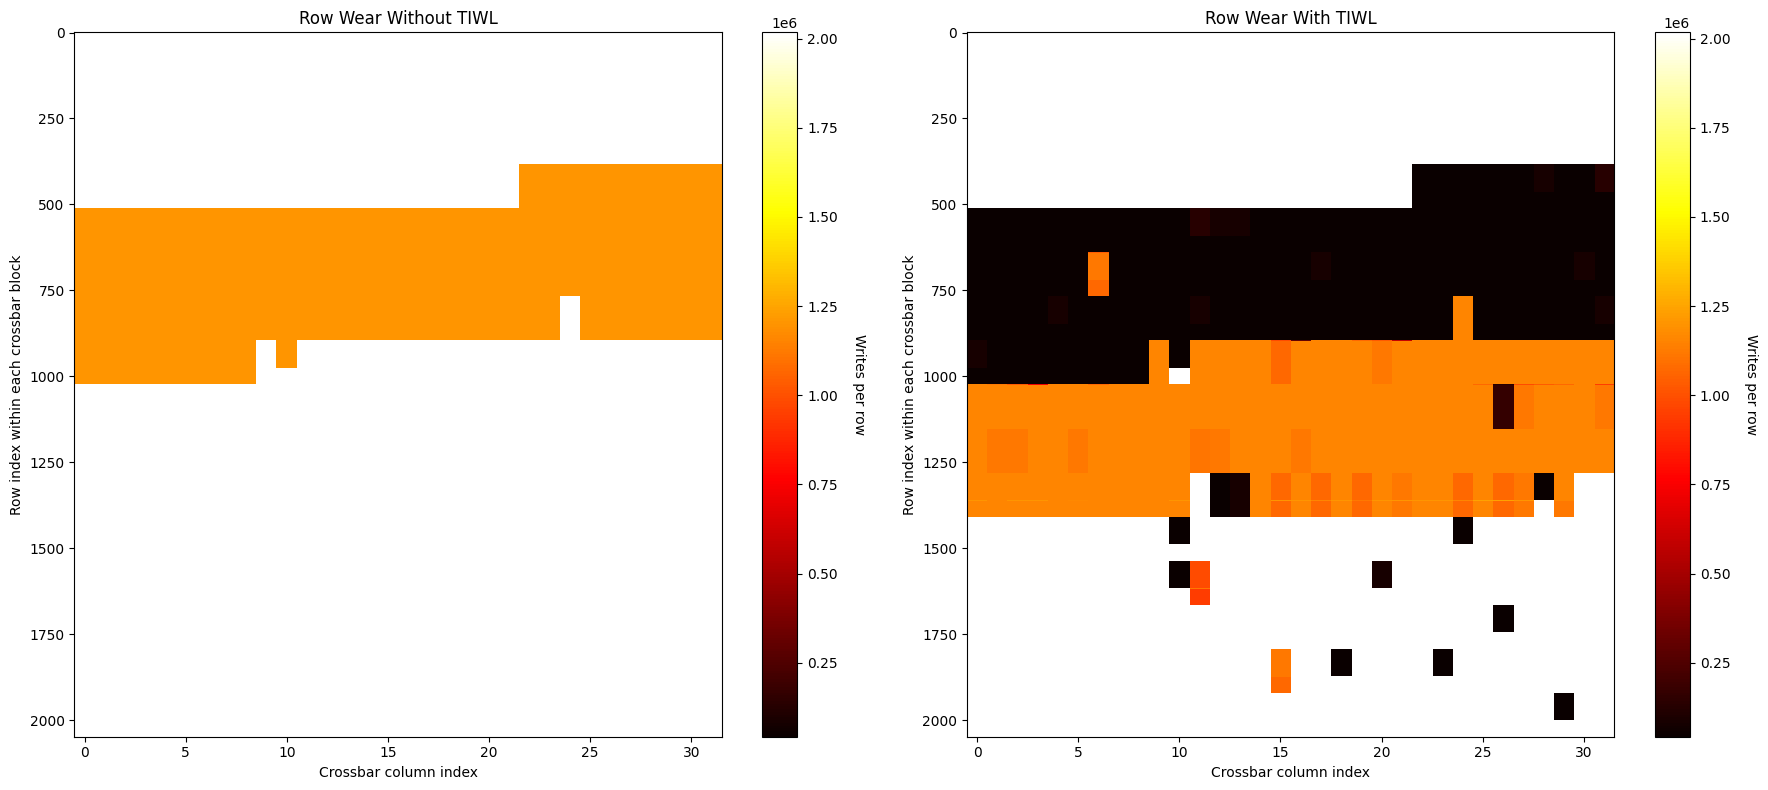

Crossbar totals from rows - reduction in max_xbar: 3.5%
Crossbar totals from rows - reduction in min_xbar: 96.4%
Crossbar totals from rows - reduction in avg_xbar: 52.3%


In [58]:
plot_row_wear_heatmap_fixed_bg(pim_simulator_no_wear_levelling, pim_sim, grid_shape=(16, 32), save_path="row_heatmap.png")

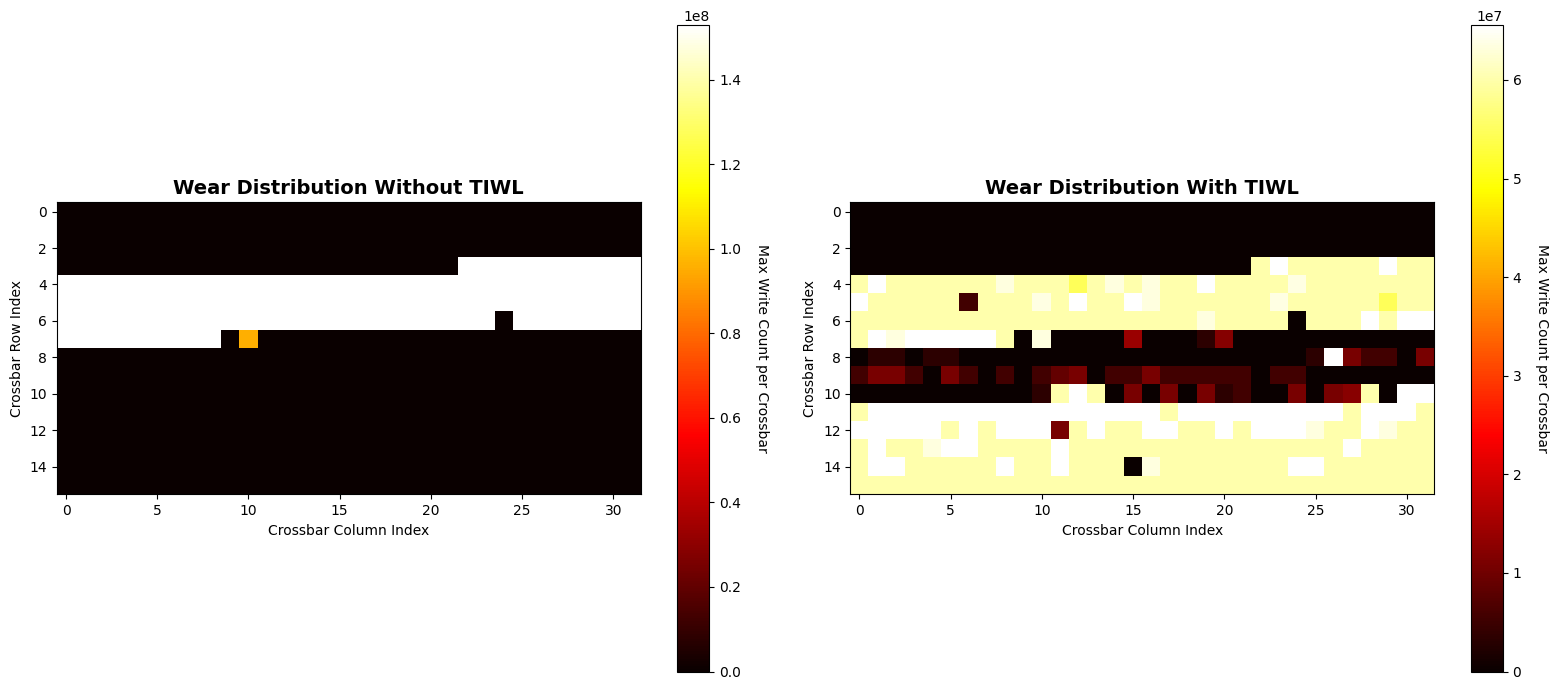

Without TIWL - Max: 152,911,872, Min: 0
With TIWL    - Max: 65,552,384, Min: 0
Wear reduction: 57.1%


In [32]:
plot_crossbar_wear_heatmap(pim_simulator_no_wear_levelling, pim_sim, grid_shape=(16, 32), save_path="heatmap.png")